# Bayesian Statistical Modeling: Quantitative Asset Pricing Through a Bayesian Approach

#### Eason Cai

**Date:** 2025-02-16

## 1. Introduction

In modern finance, the distinction between **trading** and **investing** is critical. Both involve buying and selling assets with the intention of generating returns; however, the underlying philosophies differ:

- **Trading:** Focuses on short-term buy and sell with techniques in rigorous quantitative models and rapid execution. Systematic funds, like those pioneered by Jim Simons (the godfather of quantitative finance), exemplify this approach.
- **Investing:** Focuses on long-term buy and sell, drawing on macroeconomic themes, qualitative assessments, and fundamental analyses, as seen with firms like Bridgewater Associates implementing majority proprietary strategies.

### Bayesian Perspective

A Bayesian framework allows us to combine **prior** knowledge (long-term, qualitative insights) with **likelihood** information (short-term, quantitative signals) to form a **posterior** distribution. From this empircal quantitative finance research report, the posterior we find can guide our trading decisions based on asset's true value for future returns.

## 2. Conceptual Approach

1. **Prior (Qualitative Inputs)**
   - Macroeconomic indicators such as GDP growth, inflation rates.
   - Market sentiment from financial news, social media, and analyst reports.
   - Historical context regarding economic cycles and monetary policy.

2. **Likelihood (Quantitative Signals)**
   - Statistical or machine learning models such as time-series analysis, factor models.
   - High-frequency/daily price data capturing short-term market fluctuations.
   - Feature engineering using moving averages, volatility measures, trading volumes.

3. **Posterior (Trading Execution)**
   - The posterior distribution combines the qualitative and quantitative insights to provide a probability distribution for future returns.
   - Trades are executed only when the posterior probability of a favorable outcome is high.
   - Incorporate risk management protocols in place such as stop-loss levels, position sizing.

By fusing investing (long-term qualitative signals) with trading (short-term quantitative signals), this approach aims to deliver robust, dynamic trading strategies.

## 3. Data Set from Alpha Vantage APIs

We will use the Alpha Vantage API to obtain market data since Alpha Vantage is easy assessible, free and most importantly it has eight different categories: 

1) Core Time Series Stock Data APIs
2) US Options Data APIs
3) Alpha Intelligence™
4) Fundamental Data
5) Physical and Digital/Crypto Currencies
6) Commodities
7) Economic Indicators
8) Technical Indicators

Below, we use Python’s `requests` library to fetch historical daily adjusted data for **SPY** (a proxy for the S&P 500). 

The SPDR S&P 500 ETF Trust is an exchange-traded fund which trades on the NYSE Arca under the symbol SPY. The ETF is designed to track the S&P 500 index by holding a portfolio comprising all 500 companies on the index. It is a part of the SPDR family of ETFs and is managed by State Street Global Advisors. We choose **SPY** because it is suitable for any investors who want to include U.S. equities in their portfolio while taking only a moderate level of risk.

If you would like to reproduce all the following code, please enter your own free API key from [Alpha Vantage](https://www.alphavantage.co/support/#api-key) in the `url` variable below.

In [7]:
import requests
import json
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from private import API_KEY # Store API Key in a separate file for privacy

# Make sure set up your free Alpha Vantage API key to reproduce all code
symbol = "SPY"

# Construct the API URL for monthly adjusted time series data (free endpoint)
url = (
    f"https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={symbol}"
    f"&apikey={API_KEY}"
)
response = requests.get(url)

# Parse the JSON response
data_raw = response.json()

# Convert the dictionary to a DataFrame
ts_data = data_raw["Monthly Adjusted Time Series"]
df = pd.DataFrame.from_dict(ts_data, orient='index')
df.index = pd.to_datetime(df.index)

# Rename columns for clarity
df = df.rename(columns={
    "1. open": "open",
    "2. high": "high",
    "3. low": "low",
    "4. close": "close",
    "5. adjusted close": "adjusted_close",
    "6. volume": "volume",
    "7. dividend amount": "dividend_amount"
})

# Ensure the data is sorted by date increasing order for plotting
df = df.sort_index()
cols_name = ["open", "high", "low", "close", "adjusted_close", "volume", "dividend_amount"]
for i in cols_name:
    df[i] = pd.to_numeric(df[i])

df.head()

,open,high,low,close,adjusted_close,volume,dividend_amount
1999-12-31,139.3125,147.5625,139.0000,146.8750,93.5326,121529300,0.3476
2000-01-31,148.2500,148.2500,135.0000,139.5625,88.8758,156770800,0.0000
2000-02-29,139.7500,144.5625,132.7187,137.4375,87.5226,186938300,0.0000
2000-03-31,137.6250,155.7500,135.0312,150.3750,96.0031,247594900,0.3708
2000-04-28,150.1250,153.1093,133.5000,145.0937,92.6314,229246200,0.0000


## 4. Visualize the SPY Data

We now plot the **adjusted close price** of SPY and mark two significant events:

- **2008 Housing Market Crash**
- **2022 COVID Market Impact**

The following code uses `matplotlib` to generate the plot. Let's see how the market behaves over approximately 20 years.

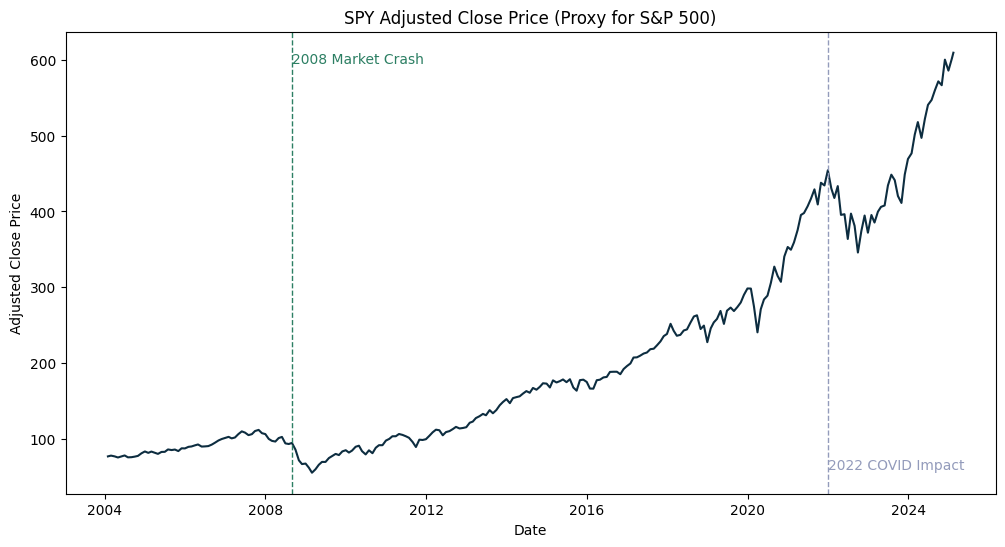

In [12]:
df = df.loc[df.index >= '2004-01-01']

plt.figure(figsize=(12,6))
plt.plot(df.index, df['adjusted_close'], color='#0D2D40')
plt.title('SPY Adjusted Close Price (Proxy for S&P 500)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')

# Mark the 2008 market crash
plt.axvline(x=pd.to_datetime('2008-09-01'), color='#2C7F63', linestyle='dashed', linewidth=1)
plt.text(pd.to_datetime('2008-09-01'), df['adjusted_close'].max(), '2008 Market Crash', color='#2C7F63', verticalalignment='top')

# Mark the 2022 covid market impact
plt.axvline(x=pd.to_datetime('2022-01-01'), color='#939BBB', linestyle='dashed', linewidth=1)
plt.text(pd.to_datetime('2022-01-01'), df['adjusted_close'].min(), '2022 COVID Impact', color='#939BBB', verticalalignment='bottom')

plt.show()

## 5. Preliminary Result using Hypothetical Scenario

### 5.1 Prior Function (Qualitative Inputs)
- This function combines macroeconomic data and news sentiment into a single prior signal.

In [14]:
def prior_function(macro_data, news_sentiment, prior_sd=0.05):
    """
    Combine macroeconomic data and news sentiment into a prior distribution.
    Returns a dictionary representing a normal distribution with a calculated mean and a specified standard deviation.
    """
    macro_score = np.mean(macro_data)
    sentiment_score = np.mean(news_sentiment)
    # Weighted sum (70% macro, 30% sentiment)
    prior_mean = 0.7 * macro_score + 0.3 * sentiment_score
    return {"distribution": "normal", "mean": prior_mean, "sd": prior_sd}

macro_example = [0.01, 0.02, 0.015, 0.03]     # monthly growth rates (in decimal)
news_example = [0.012, 0.011, 0.013, 0.012]   # news sentiment scores (in decimal)

prior_dist = prior_function(macro_example, news_example, prior_sd=0.05)
print("Prior Distribution:", prior_dist)

Prior Distribution: {'distribution': 'normal', 'mean': 0.016725, 'sd': 0.05}


### 5.2 Likelihood Function (Quantitative Signals)
- This function calculates daily returns from price data and produces a likelihood distribution based on the returns.

In [15]:
def likelihood_function(price_data, inflate_sd=1):
    """
    Calculate log returns from price data and return a likelihood distribution
    (assumed to be normal) with estimated mean and standard deviation.
    The inflation factor makes the likelihood less (or more) precise.
    """
    price_data = np.array(price_data)
    returns = np.diff(np.log(price_data))
    mu = np.mean(returns)
    sigma = np.std(returns) * inflate_sd  # Using no inflation (inflate_sd=1) so that likelihood is more informative.
    return {"distribution": "normal", "mean": mu, "sd": sigma}

# For the likelihood, we use the last 100 data points from adjusted_close
price_data_example = df['adjusted_close'].tail(100).values  
likelihood_dist = likelihood_function(price_data_example, inflate_sd=1)
print("Likelihood Distribution:", likelihood_dist)

Likelihood Distribution: {'distribution': 'normal', 'mean': 0.011683648952588204, 'sd': 0.04558755435149986}


### 5.3 Posterior Function (Trading Execution)
- This function calculates daily returns from price data and produces a likelihood distribution based on the returns.

Posterior Distribution: {'distribution': 'normal', 'mean': 0.013972103995349566, 'sd': 0.03368741811359867}


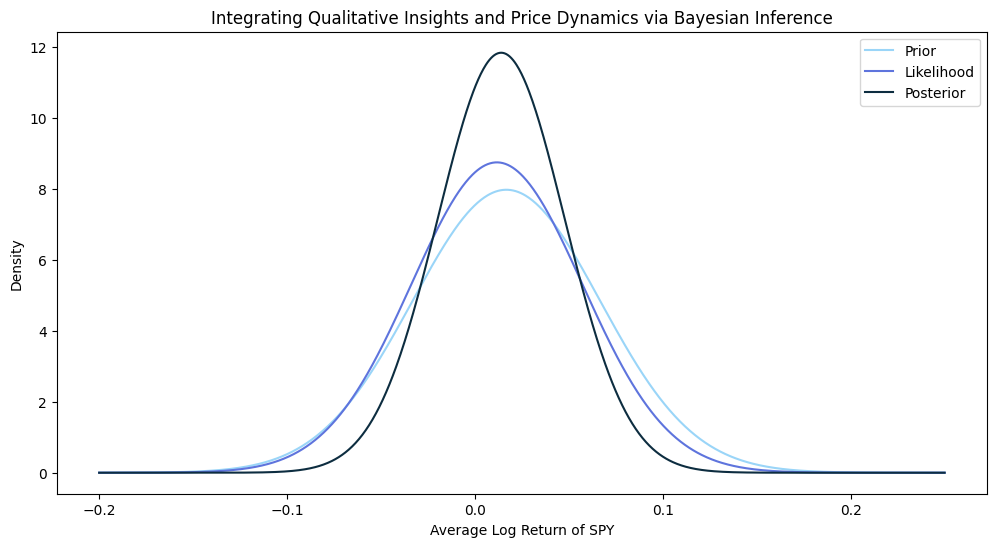

In [19]:
def posterior_function(prior, likelihood):
    """
    Combine a normal prior and a normal likelihood (conjugate case)
    to form a normal posterior.
    """
    prior_mean = prior['mean']
    prior_sd = prior['sd']
    likelihood_mean = likelihood['mean']
    likelihood_sd = likelihood['sd']
    
    posterior_mean = (likelihood_sd**2 * prior_mean + prior_sd**2 * likelihood_mean) / (prior_sd**2 + likelihood_sd**2)
    posterior_sd = np.sqrt((prior_sd**2 * likelihood_sd**2) / (prior_sd**2 + likelihood_sd**2))
    
    return {"distribution": "normal", "mean": posterior_mean, "sd": posterior_sd}

# Compute the posterior.
posterior_dist = posterior_function(prior_dist, likelihood_dist)
print("Posterior Distribution:", posterior_dist)

# Create an x-axis grid that covers the range of interest.
x = np.linspace(-0.2, 0.25, 1000)

plt.figure(figsize=(12, 6))
plt.plot(x, norm.pdf(x, prior_dist['mean'], prior_dist['sd']), label="Prior", color='#9AD5F8')
plt.plot(x, norm.pdf(x, likelihood_dist['mean'], likelihood_dist['sd']), label="Likelihood", color='#5E74DD')
plt.plot(x, norm.pdf(x, posterior_dist['mean'], posterior_dist['sd']), label="Posterior", color='#0D2D40')
plt.title("Integrating Qualitative Insights and Price Dynamics via Bayesian Inference")
plt.xlabel("Average Log Return of SPY")
plt.ylabel("Density")
plt.legend()
plt.show()

This graph illustrates how integrating **qualitative insights** (macro and sentiment) with **observed price data** shifts and refines our belief about the parameter in question, culminating in the posterior distribution.

## 6. Avoiding Overfitting the Model

To ensure the model generalizes well and does not simply capture noise, consider the following steps:

1. **Data Partitioning**
   - Split the dataset into training, validation, and test sets.

2. **Cross-Validation**
   - Use techniques like *k*-fold cross-validation to assess model stability across different data segments.

3. **Regularization Techniques**
   - Apply L1 (Lasso) or L2 (Ridge) regularization to penalize model complexity.
   - In a Bayesian context, use informative priors (Bayesian shrinkage) to prevent extreme parameter estimates.

4. **Backtesting and Forward Testing**
   - Validate the model on historical data (backtesting) and through live or simulated trading (forward testing).

## 7. Conclusion

By reframing **investing** as a **prior** (long-term qualitative insights) and **trading** as a **likelihood** (short-term quantitative signals), this Bayesian approach provides a unified framework for making informed, risk-managed trading decisions.

**Citations**
 -   Investopedia. (2015, December 22). *SPDR S&P 500 ETF Trust*. Retrieved from [https://www.investopedia.com/articles/investing/122215/spy-spdr-sp-500-trust-etf.asp](https://www.investopedia.com/articles/investing/122215/spy-spdr-sp-500-trust-etf.asp)
 -   Alpha Vantage. (n.d.). *Documentation*. Retrieved February 16, 2025, from [https://www.alphavantage.co/documentation/#](https://www.alphavantage.co/documentation/#)

**License**
 -   GNU general public license v3.0.
 
**Copyright**
 -   Copyright © 2025, [**Eason Cai**].